In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR 
import torchvision.transforms.functional as F

import numpy as np
import os
import sys
import json
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from tqdm import tqdm

from sklearn.model_selection import train_test_split

# pv_vision_dir = os.path.join(Path.home(), 'pv-vision')
pv_vision_dir = os.path.join('/home/eccoope', 'pv-vision')
# functions_dir = os.path.join(Path.home(), 'el_img_cracks_ec', 'scripts')
functions_dir = os.path.join('/home/eccoope', 'el_img_cracks_ec', 'scripts')

sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

# ojas_functions_dir = os.path.join(Path.home(), 'pvcracks/retrain/')
ojas_functions_dir = "/home/nrjost/githome/pvcracks/retrain/"
sys.path.append(ojas_functions_dir)

from tutorials.unet_model import construct_unet
import functions
from torch.utils.data import random_split
import wandb


In [2]:
root = "/home/nrjost/githome/pvcracks_dev/retrain/training/Channeled_Combined_CWRU_LBNL_ASU/"


model_weight_paths = {
    "emma_retrained": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt",
    "original": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/pv-vision_model.pt",
}

# weight_path = model_weight_paths["emma_retrained"]
weight_path = model_weight_paths["original"]

checkpoint_name = root.split("/")[-2]

In [3]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

In [4]:
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice

def iou_score(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou


In [5]:
def load_dataset(root):
    transformers = functions.Compose([functions.ChanneledFixResize(256), functions.ToTensor(), functions.Normalize()])
    
    full_dataset = functions.SolarDataset(
        root, image_folder="img/all", mask_folder="ann/all", transforms=transformers
    )

    return full_dataset

In [6]:
def load_device_and_model(weight_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("mps")
    unet = construct_unet(len(category_mapping))
    unet = torch.nn.DataParallel(unet)
    
    model = unet.module.to(device)
    
    return device, model

In [7]:
def get_save_dir(base_dir, checkpoint_name):
    checkpoint_dir = base_dir + "/checkpoints/"
    folders = [folder for folder in os.listdir(checkpoint_dir)]
    
    max_number = 0
    for folder in folders:
        number = int(folder[-1])
        if number > max_number:
            max_number = number

    new_folder_name = f"{checkpoint_name}{max_number + 1}"
    new_folder_path = os.path.join(checkpoint_dir, new_folder_name)
    
    os.makedirs(new_folder_path, exist_ok=True)
    
    return new_folder_path

In [8]:
full_dataset = load_dataset(root)

In [9]:
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_subset, test_subset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

In [10]:
# this is needed so that we can a) split the dataset into train/test while ensuring our seed is the same as the wandb_k_fold, b) and preserver stuff like __getraw__ from solardataset when doing inference

class SubsetWithRaw(torch.utils.data.Subset):
    def __getraw__(self, idx):
        return self.dataset.__getraw__(self.indices[idx])

train_set = SubsetWithRaw(full_dataset, train_subset.indices)
test_set = SubsetWithRaw(full_dataset, test_subset.indices)

In [11]:
device, model = load_device_and_model(weight_path)

In [12]:
import matplotlib.pyplot as plt

def new_inference_and_show(idx, threshold=0.5):
    # Get the preprocessed image and multi-hot ground truth mask
    img, mask = test_loader.dataset.__getitem__(idx)
    img = img.to(device)
    
    # Get the raw image for display (assuming __getraw__ returns a PIL image)
    raw_img, _ = test_loader.dataset.__getraw__(idx)
    
    # --- Run inference ---
    # Get raw logits from the model, then apply Sigmoid and threshold
    logits = model(img.unsqueeze(0)).detach().cpu()  # shape: [1, 4, H, W]
    probs = torch.sigmoid(logits)                     # shape: [1, 4, H, W]
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # shape: [4, H, W]
    
    # Ground truth is assumed to be already a 4-channel multi-hot mask.
    gt_mask = mask.cpu().numpy()  # shape: [4, H, W]
    
    # --- Visualization ---
    # Create a grid with 3 rows and 4 columns:
    #   Row 0: Raw image (displayed only once in the first column)
    #   Row 1: Ground truth masks for each class
    #   Row 2: Predicted masks for each class
    n_classes = len(category_mapping)
    class_names = [f'({k}) {v}' for k, v in category_mapping.items()]
    
    fig, axs = plt.subplots(3, n_classes, figsize=(4*n_classes, 12))
    
    # Row 0: Display raw image in first subplot; hide other subplots in this row.
    axs[0, 0].imshow(raw_img.convert('L'), cmap='viridis')
    axs[0, 0].set_title("Raw Image")
    axs[0, 0].axis('off')
    for j in range(1, n_classes):
        axs[0, j].axis('off')
    
    # Row 1: Ground truth for each class (each channel)
    for j in range(n_classes):
        axs[1, j].imshow(gt_mask[j], cmap='viridis')
        axs[1, j].set_title(f"GT: {class_names[j]}")
        axs[1, j].axis('off')
    
    # Row 2: Predictions for each class (each channel)
    for j in range(n_classes):
        axs[2, j].imshow(pred_mask[j], cmap='viridis')
        axs[2, j].set_title(f"Pred: {class_names[j]}")
        axs[2, j].axis('off')
    
    fig.suptitle("Retrained Model Prediction", fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Training

In [13]:
save_name = "model.pt"
save_dir = get_save_dir(str(root), checkpoint_name)
os.makedirs(save_dir, exist_ok=True)

original_config = {
    "batch_size_train": 32,
    "lr": 0.00074531,#wandb run:playful-shape-234 #0.00092234,
    "gamma": 0.19051,#wandb #0.11727,
    "num_epochs": 50,#wandb
    
    # constants
    "batch_size_test": 32, #check VAE 
    "criterion": torch.nn.BCEWithLogitsLoss(),
    "k_folds": 5,
    # "lr_scheduler_step_size": 1,
}

config_serializable = original_config.copy()
config_serializable["criterion"] = str(config_serializable["criterion"])

with open(os.path.join(save_dir, "config.json"), "w", encoding="utf-8") as f:
    json.dump(config_serializable, f, ensure_ascii=False, indent=4)

run = wandb.init(
    project="pvcracks",
    entity="ojas-sanghi-university-of-arizona",
    config=original_config,
)
config = wandb.config

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ojas-sanghi (ojas-sanghi-university-of-arizona) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [14]:
train_loader = DataLoader(train_set, batch_size=config.batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=config.batch_size_test, shuffle=False)

In [15]:
optimizer = Adam(model.parameters(), lr=config.lr)

# log gradients
run.watch(model, log_freq=100)

In [16]:
training_epoch_loss = []
test_epoch_loss = []
test_dice_loss = []
test_iou_loss = []

best_epoch_test_loss = float("inf")
best_epoch_dice = 0.0
best_epoch_iou = 0.0

for epoch in tqdm(range(1, config.num_epochs + 1)):
    
    training_step_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = target.float()
        
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # calc loss -- bce with logits loss applies sigmoid interally
        training_loss = original_config["criterion"](output, target)
        #backward pass
        training_loss.backward()
        optimizer.step()
        # record loss
        training_step_loss.append(training_loss.item())
        
    test_step_loss = []
    dice_scores = []
    iou_scores = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        target = target.float()
        # forward pass
        # data = data.to(device)
        output = model(data)
        
        # calc loss -- bce with logits loss applies sigmoid interally
        test_loss = original_config["criterion"](output, target)
        test_step_loss.append(test_loss.item())
        
        # compute dice and iou
        pred_probs = torch.sigmoid(output)
        pred_binary = (pred_probs > 0.5).float()
        for i in range(pred_binary.size(1)):
            dice = dice_coefficient(pred_binary[:, i], target[:, i])
            iou = iou_score(pred_binary[:, i], target[:, i])
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())
        
    epoch_train_loss = np.mean(training_step_loss)
    epoch_test_loss = np.mean(test_step_loss)
    epoch_avg_dice = np.mean(dice_scores)
    epoch_avg_iou = np.mean(iou_scores)
    
    training_epoch_loss.append(epoch_train_loss)
    test_epoch_loss.append(epoch_test_loss)
    test_dice_loss.append(epoch_avg_dice)
    test_iou_loss.append(epoch_avg_iou)
    
    run.log({
        "train_loss": epoch_train_loss,
        "test_loss": epoch_test_loss,
        "avg_dice": epoch_avg_dice,
        "avg_iou": epoch_avg_iou,
    }, step=epoch)
    
    
    if epoch_test_loss < best_epoch_test_loss:
        best_epoch_test_loss = epoch_test_loss
        best_epoch_dice = epoch_avg_dice
        best_epoch_iou = epoch_avg_iou
        
        os.makedirs(os.path.join(save_dir, f'epoch_{epoch}'), exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, f'epoch_{epoch}', save_name))
        print(f'Saved model at epoch {epoch}')

    print(f"Epoch {epoch} best test_loss: {best_epoch_test_loss:.4f}, dice: {best_epoch_dice:.4f}, iou: {best_epoch_iou:.4f}")

  2%|▏         | 1/50 [01:40<1:22:01, 100.44s/it]

Saved model at epoch 1
Epoch 1 best test_loss: 0.1800, dice: 0.6155, iou: 0.5295


  4%|▍         | 2/50 [02:11<47:44, 59.67s/it]   

Saved model at epoch 2
Epoch 2 best test_loss: 0.0971, dice: 0.6356, iou: 0.5539


  6%|▌         | 3/50 [02:43<36:40, 46.82s/it]

Saved model at epoch 3
Epoch 3 best test_loss: 0.0694, dice: 0.7440, iou: 0.6327


  8%|▊         | 4/50 [03:14<31:19, 40.85s/it]

Saved model at epoch 4
Epoch 4 best test_loss: 0.0572, dice: 0.7607, iou: 0.6501


 10%|█         | 5/50 [03:46<28:09, 37.54s/it]

Saved model at epoch 5
Epoch 5 best test_loss: 0.0473, dice: 0.8365, iou: 0.7287


 12%|█▏        | 6/50 [04:17<25:59, 35.45s/it]

Saved model at epoch 6
Epoch 6 best test_loss: 0.0443, dice: 0.8445, iou: 0.7371


 14%|█▍        | 7/50 [04:49<24:29, 34.18s/it]

Saved model at epoch 7
Epoch 7 best test_loss: 0.0401, dice: 0.8663, iou: 0.7685


 16%|█▌        | 8/50 [05:20<23:19, 33.33s/it]

Saved model at epoch 8
Epoch 8 best test_loss: 0.0384, dice: 0.8676, iou: 0.7700


 18%|█▊        | 9/50 [05:52<22:22, 32.76s/it]

Saved model at epoch 9
Epoch 9 best test_loss: 0.0369, dice: 0.8724, iou: 0.7774


 20%|██        | 10/50 [06:23<21:34, 32.35s/it]

Saved model at epoch 10
Epoch 10 best test_loss: 0.0364, dice: 0.8678, iou: 0.7713


 22%|██▏       | 11/50 [06:56<20:59, 32.28s/it]

Saved model at epoch 11
Epoch 11 best test_loss: 0.0346, dice: 0.8770, iou: 0.7847


 24%|██▍       | 12/50 [07:26<20:11, 31.88s/it]

Epoch 12 best test_loss: 0.0346, dice: 0.8770, iou: 0.7847


 26%|██▌       | 13/50 [07:58<19:30, 31.63s/it]

Epoch 13 best test_loss: 0.0346, dice: 0.8770, iou: 0.7847


 28%|██▊       | 14/50 [08:29<18:56, 31.57s/it]

Saved model at epoch 14
Epoch 14 best test_loss: 0.0342, dice: 0.8764, iou: 0.7835


 30%|███       | 15/50 [09:00<18:24, 31.55s/it]

Saved model at epoch 15
Epoch 15 best test_loss: 0.0326, dice: 0.8831, iou: 0.7938


 32%|███▏      | 16/50 [09:31<17:46, 31.37s/it]

Epoch 16 best test_loss: 0.0326, dice: 0.8831, iou: 0.7938


 34%|███▍      | 17/50 [10:02<17:11, 31.26s/it]

Epoch 17 best test_loss: 0.0326, dice: 0.8831, iou: 0.7938


 36%|███▌      | 18/50 [10:34<16:42, 31.32s/it]

Saved model at epoch 18
Epoch 18 best test_loss: 0.0325, dice: 0.8810, iou: 0.7904


 38%|███▊      | 19/50 [11:05<16:12, 31.38s/it]

Saved model at epoch 19
Epoch 19 best test_loss: 0.0321, dice: 0.8857, iou: 0.7981


 40%|████      | 20/50 [11:36<15:38, 31.27s/it]

Epoch 20 best test_loss: 0.0321, dice: 0.8857, iou: 0.7981


 42%|████▏     | 21/50 [12:07<15:04, 31.19s/it]

Epoch 21 best test_loss: 0.0321, dice: 0.8857, iou: 0.7981


 44%|████▍     | 22/50 [12:39<14:35, 31.27s/it]

Saved model at epoch 22
Epoch 22 best test_loss: 0.0320, dice: 0.8810, iou: 0.7907


 46%|████▌     | 23/50 [13:10<14:05, 31.31s/it]

Saved model at epoch 23
Epoch 23 best test_loss: 0.0310, dice: 0.8871, iou: 0.8010


 48%|████▊     | 24/50 [13:41<13:31, 31.21s/it]

Epoch 24 best test_loss: 0.0310, dice: 0.8871, iou: 0.8010


 50%|█████     | 25/50 [14:12<12:58, 31.14s/it]

Epoch 25 best test_loss: 0.0310, dice: 0.8871, iou: 0.8010


 52%|█████▏    | 26/50 [14:43<12:25, 31.08s/it]

Epoch 26 best test_loss: 0.0310, dice: 0.8871, iou: 0.8010


 54%|█████▍    | 27/50 [15:14<11:54, 31.05s/it]

Epoch 27 best test_loss: 0.0310, dice: 0.8871, iou: 0.8010


 56%|█████▌    | 28/50 [15:45<11:23, 31.05s/it]

Epoch 28 best test_loss: 0.0310, dice: 0.8871, iou: 0.8010


 58%|█████▊    | 29/50 [16:16<10:51, 31.03s/it]

Epoch 29 best test_loss: 0.0310, dice: 0.8871, iou: 0.8010


 60%|██████    | 30/50 [16:48<10:22, 31.13s/it]

Saved model at epoch 30
Epoch 30 best test_loss: 0.0305, dice: 0.8890, iou: 0.8034


 62%|██████▏   | 31/50 [17:18<09:50, 31.06s/it]

Epoch 31 best test_loss: 0.0305, dice: 0.8890, iou: 0.8034


 64%|██████▍   | 32/50 [17:50<09:20, 31.16s/it]

Saved model at epoch 32
Epoch 32 best test_loss: 0.0301, dice: 0.8945, iou: 0.8125


 66%|██████▌   | 33/50 [18:21<08:49, 31.12s/it]

Epoch 33 best test_loss: 0.0301, dice: 0.8945, iou: 0.8125


 68%|██████▊   | 34/50 [18:52<08:16, 31.03s/it]

Epoch 34 best test_loss: 0.0301, dice: 0.8945, iou: 0.8125


 70%|███████   | 35/50 [19:22<07:44, 30.95s/it]

Epoch 35 best test_loss: 0.0301, dice: 0.8945, iou: 0.8125


 72%|███████▏  | 36/50 [19:54<07:14, 31.02s/it]

Saved model at epoch 36
Epoch 36 best test_loss: 0.0301, dice: 0.8899, iou: 0.8053


 74%|███████▍  | 37/50 [20:24<06:42, 30.96s/it]

Epoch 37 best test_loss: 0.0301, dice: 0.8899, iou: 0.8053


 76%|███████▌  | 38/50 [20:56<06:12, 31.05s/it]

Saved model at epoch 38
Epoch 38 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


 78%|███████▊  | 39/50 [21:26<05:40, 30.97s/it]

Epoch 39 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


 80%|████████  | 40/50 [21:57<05:09, 30.94s/it]

Epoch 40 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


 82%|████████▏ | 41/50 [22:28<04:38, 30.92s/it]

Epoch 41 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


 84%|████████▍ | 42/50 [22:59<04:06, 30.87s/it]

Epoch 42 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


 86%|████████▌ | 43/50 [23:30<03:36, 30.88s/it]

Epoch 43 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


 88%|████████▊ | 44/50 [24:01<03:05, 30.86s/it]

Epoch 44 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


 90%|█████████ | 45/50 [24:31<02:34, 30.84s/it]

Epoch 45 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


 92%|█████████▏| 46/50 [25:02<02:03, 30.85s/it]

Epoch 46 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


 94%|█████████▍| 47/50 [25:33<01:32, 30.86s/it]

Epoch 47 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


 96%|█████████▌| 48/50 [26:04<01:01, 30.87s/it]

Epoch 48 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


 98%|█████████▊| 49/50 [26:35<00:30, 30.90s/it]

Epoch 49 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


100%|██████████| 50/50 [27:06<00:00, 32.53s/it]

Epoch 50 best test_loss: 0.0296, dice: 0.8923, iou: 0.8090


In [17]:
run.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


avg_dice,▁▂▄▅▇▇▇▇▇██▇▇██████▇████████████████████
avg_iou,▁▂▄▆▆▇▇▇▇▇█▇▇▇██▇██▇████████████████████
test_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_dice,0.89164
avg_iou,0.80807
test_loss,0.03274
train_loss,0.018


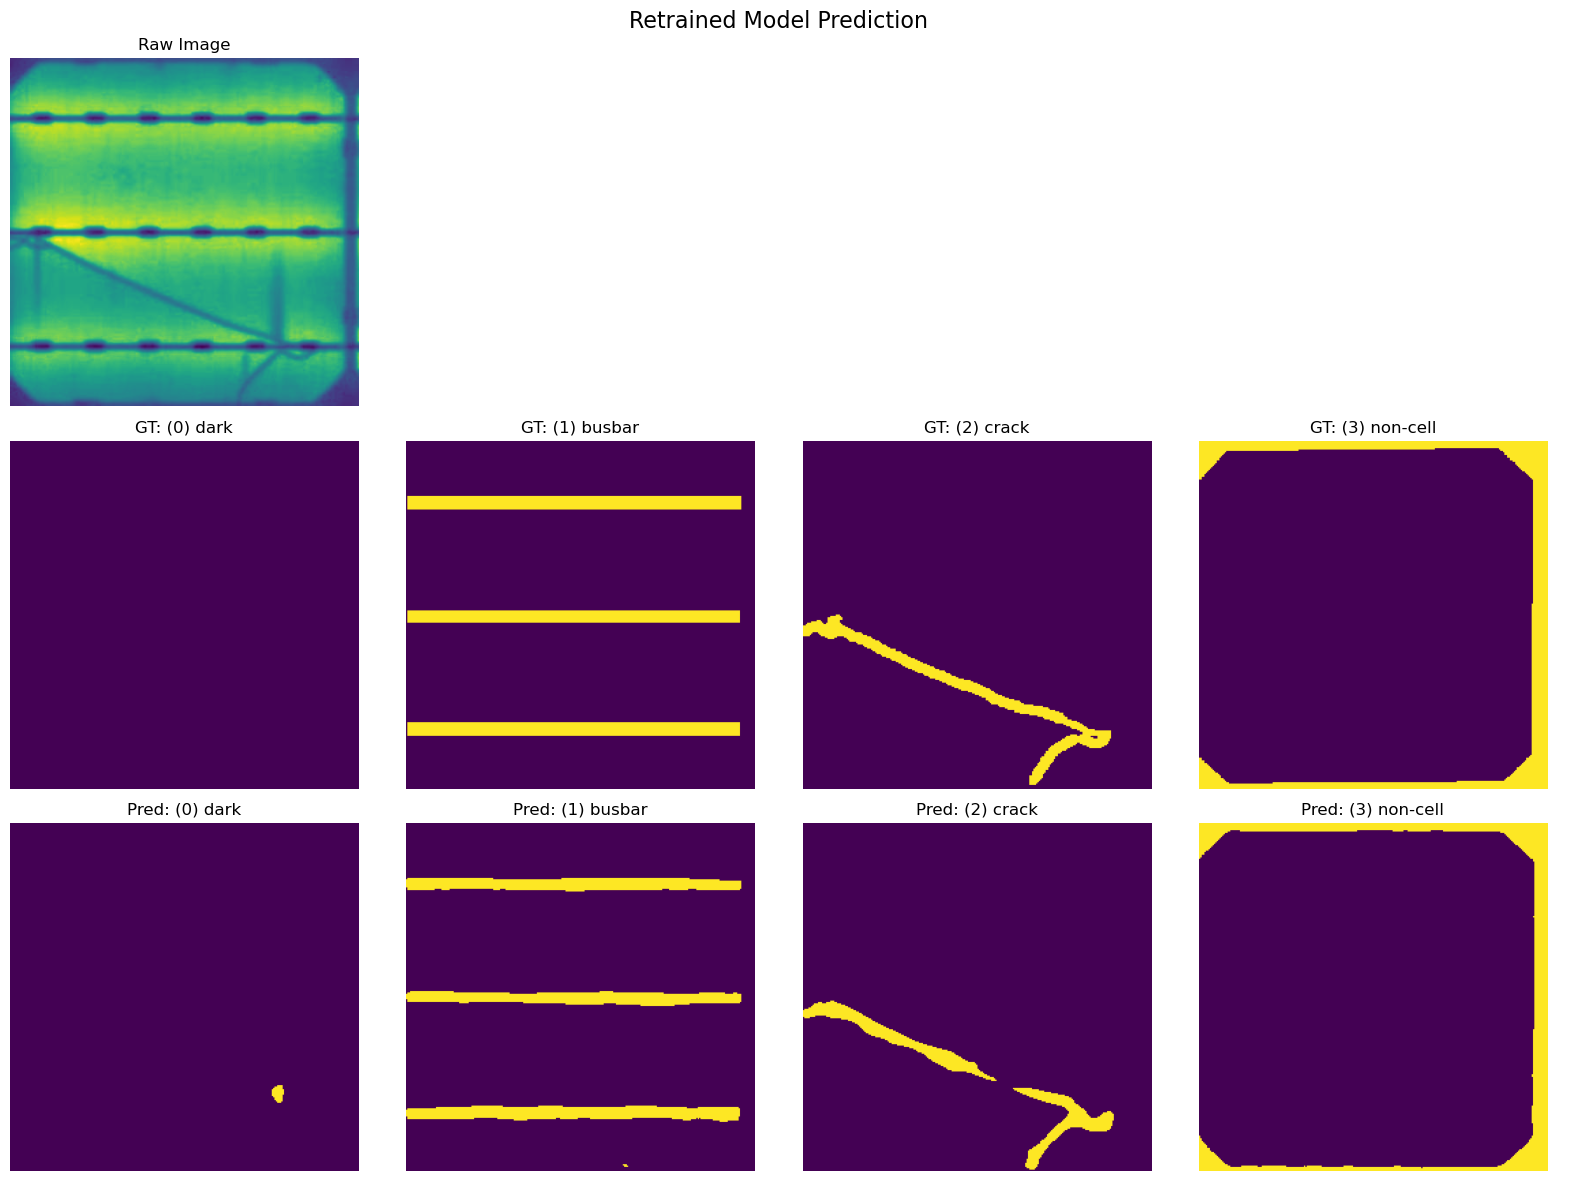

In [18]:
new_inference_and_show(-32)

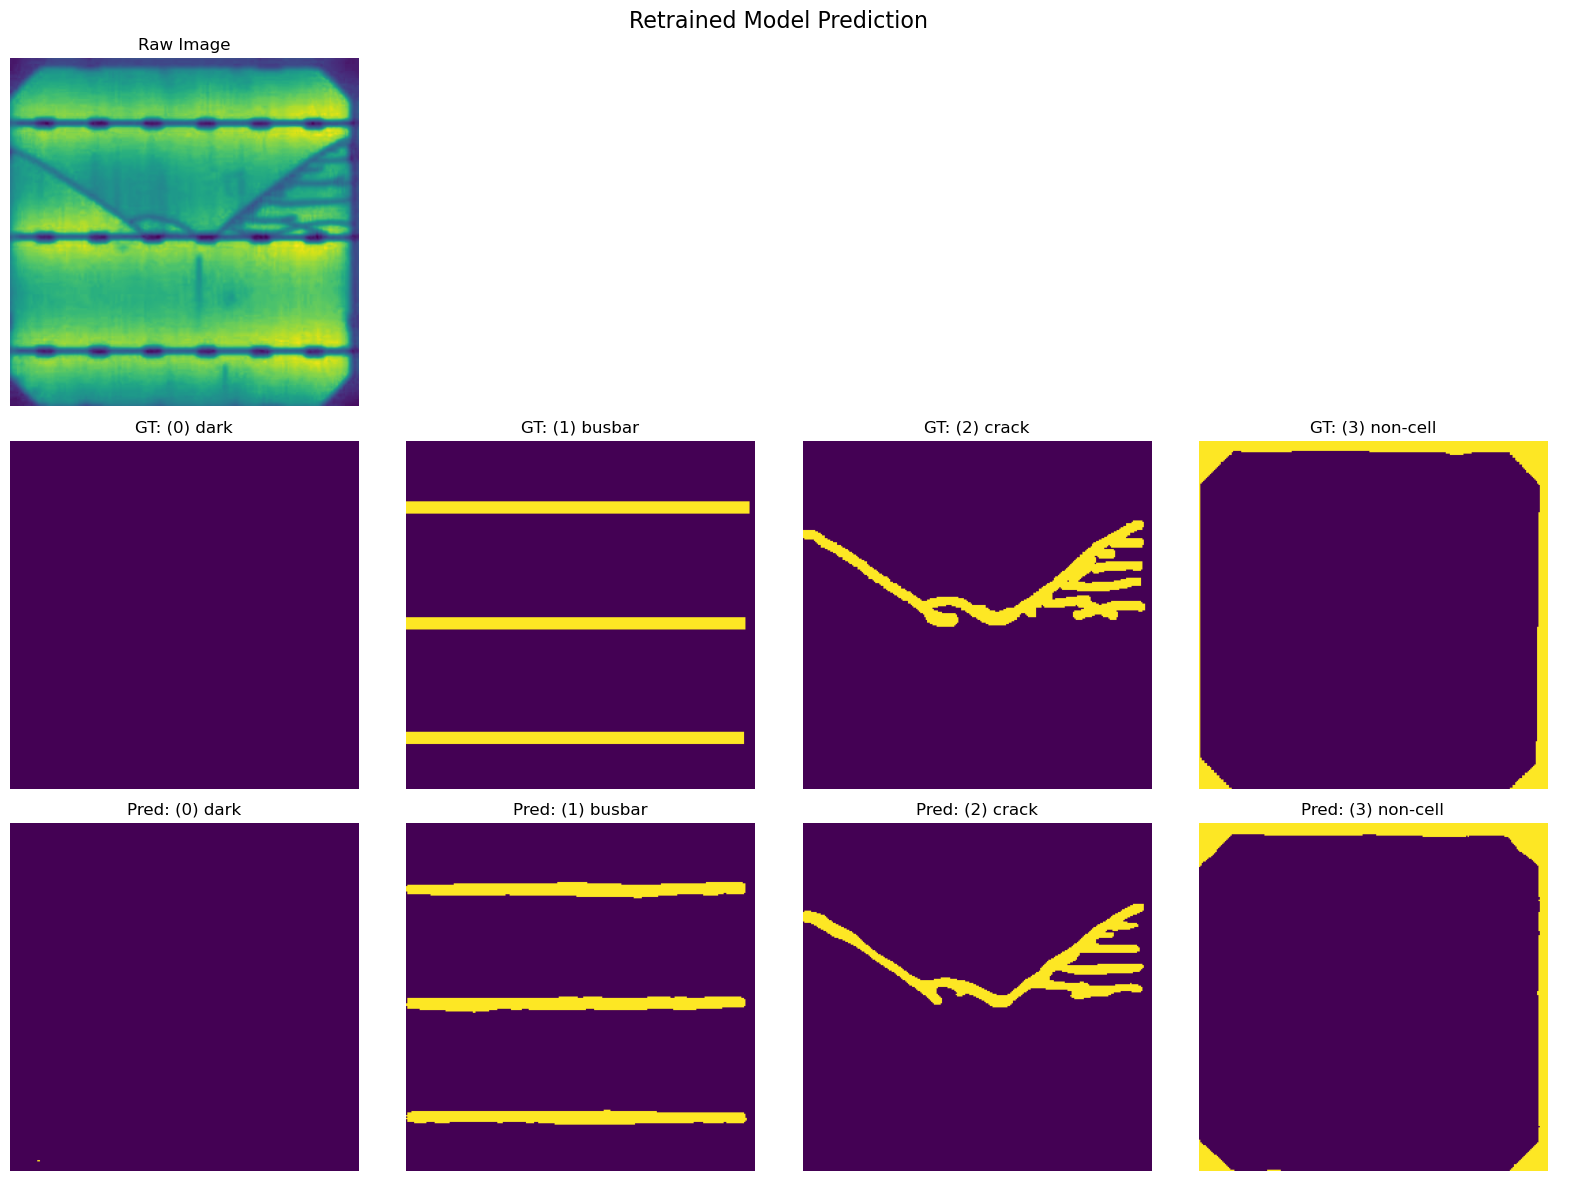

In [19]:
new_inference_and_show(13)

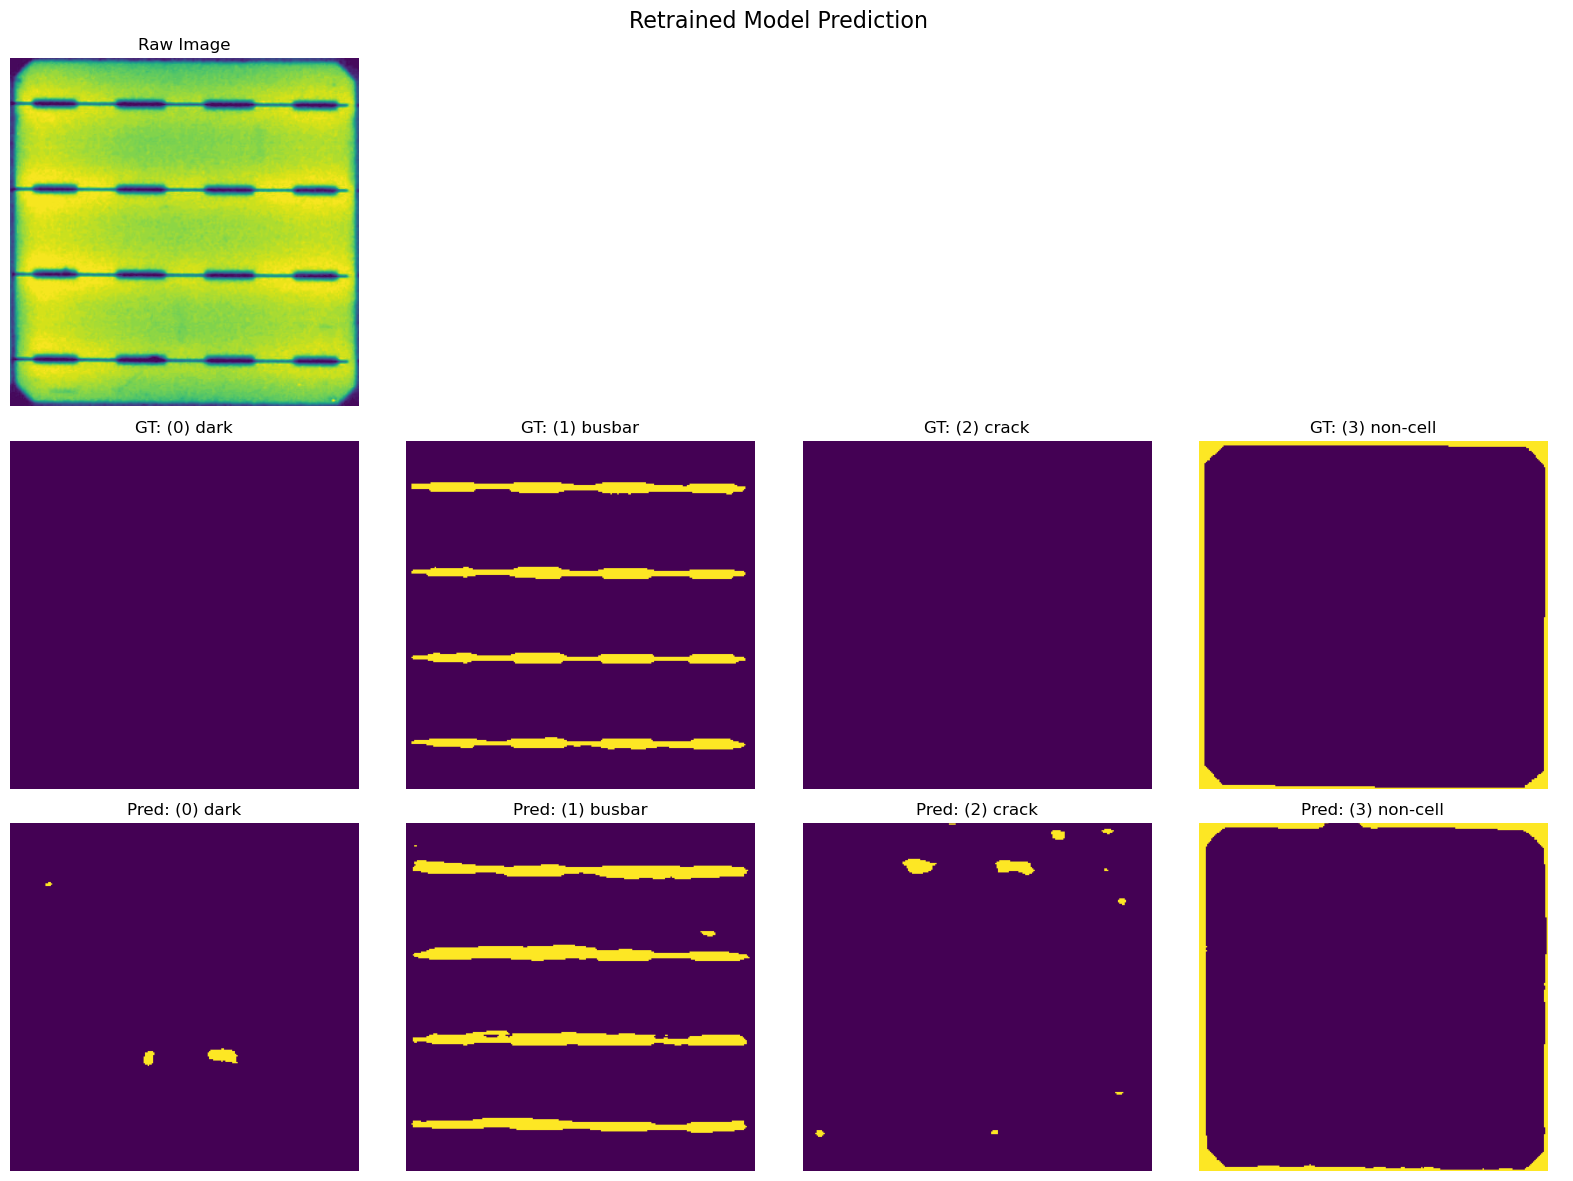

In [20]:
new_inference_and_show(44)

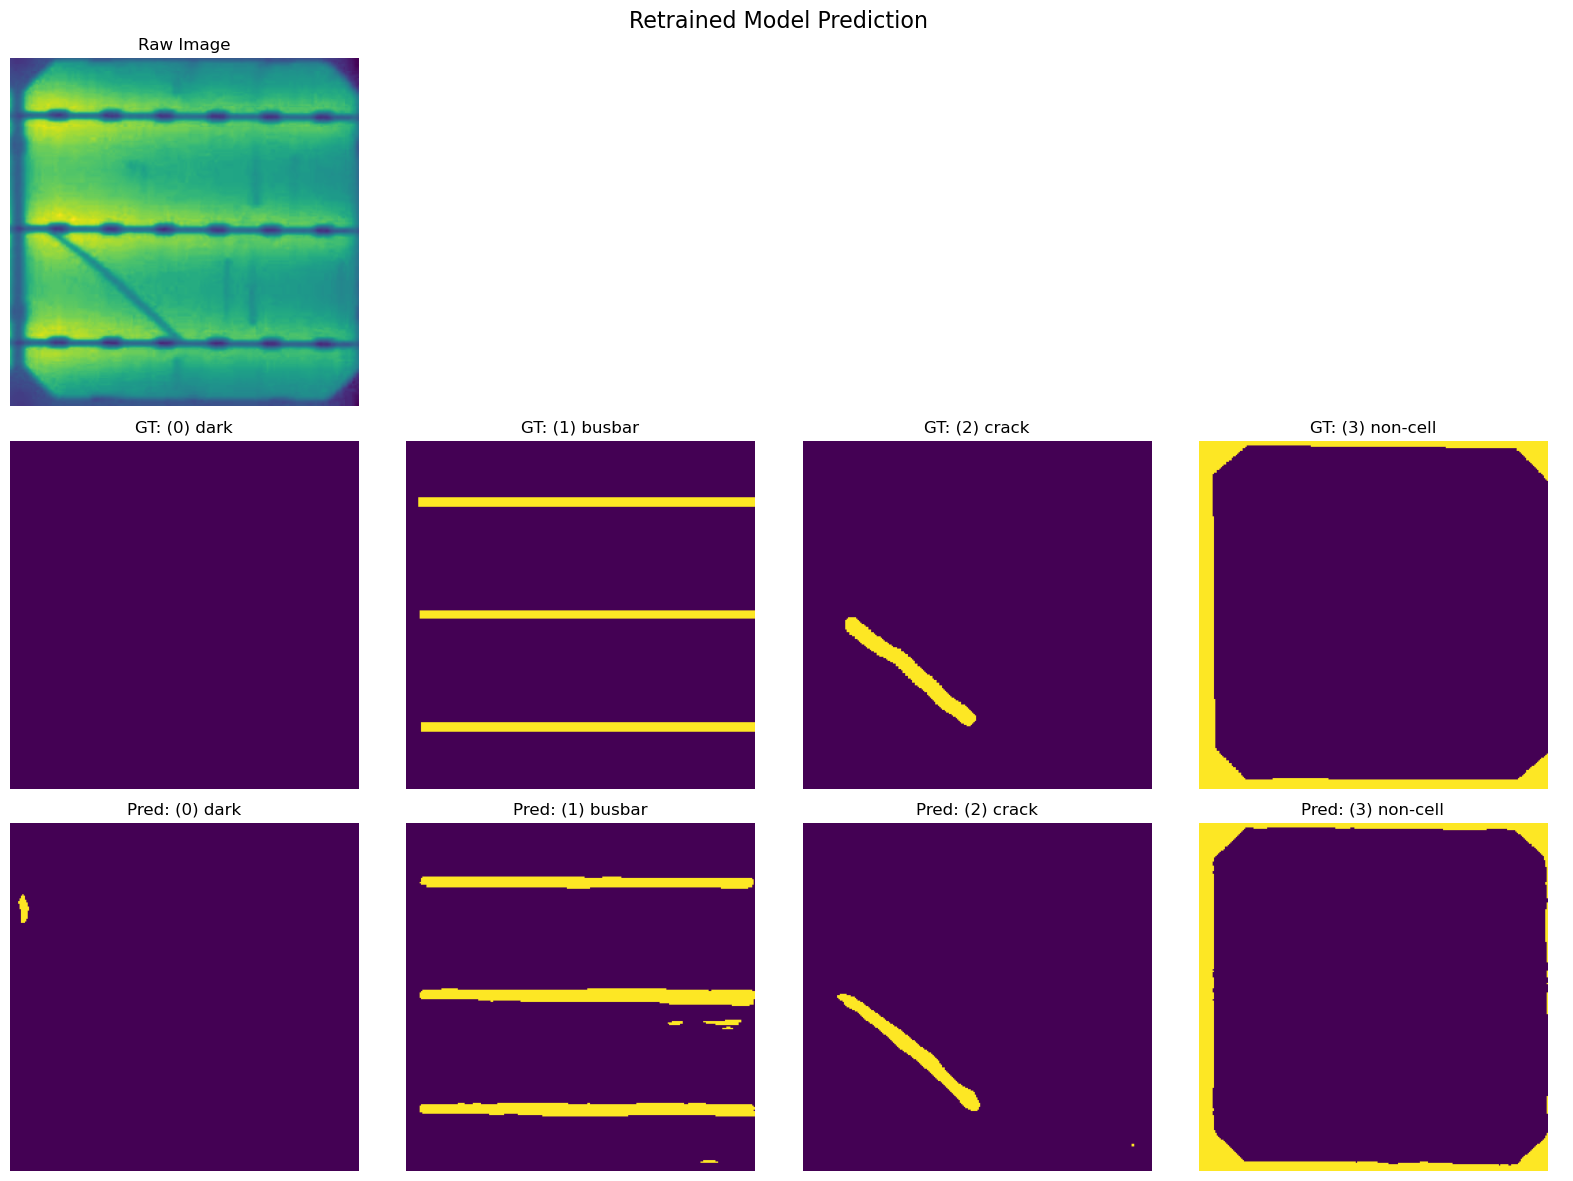

In [21]:
new_inference_and_show(1)

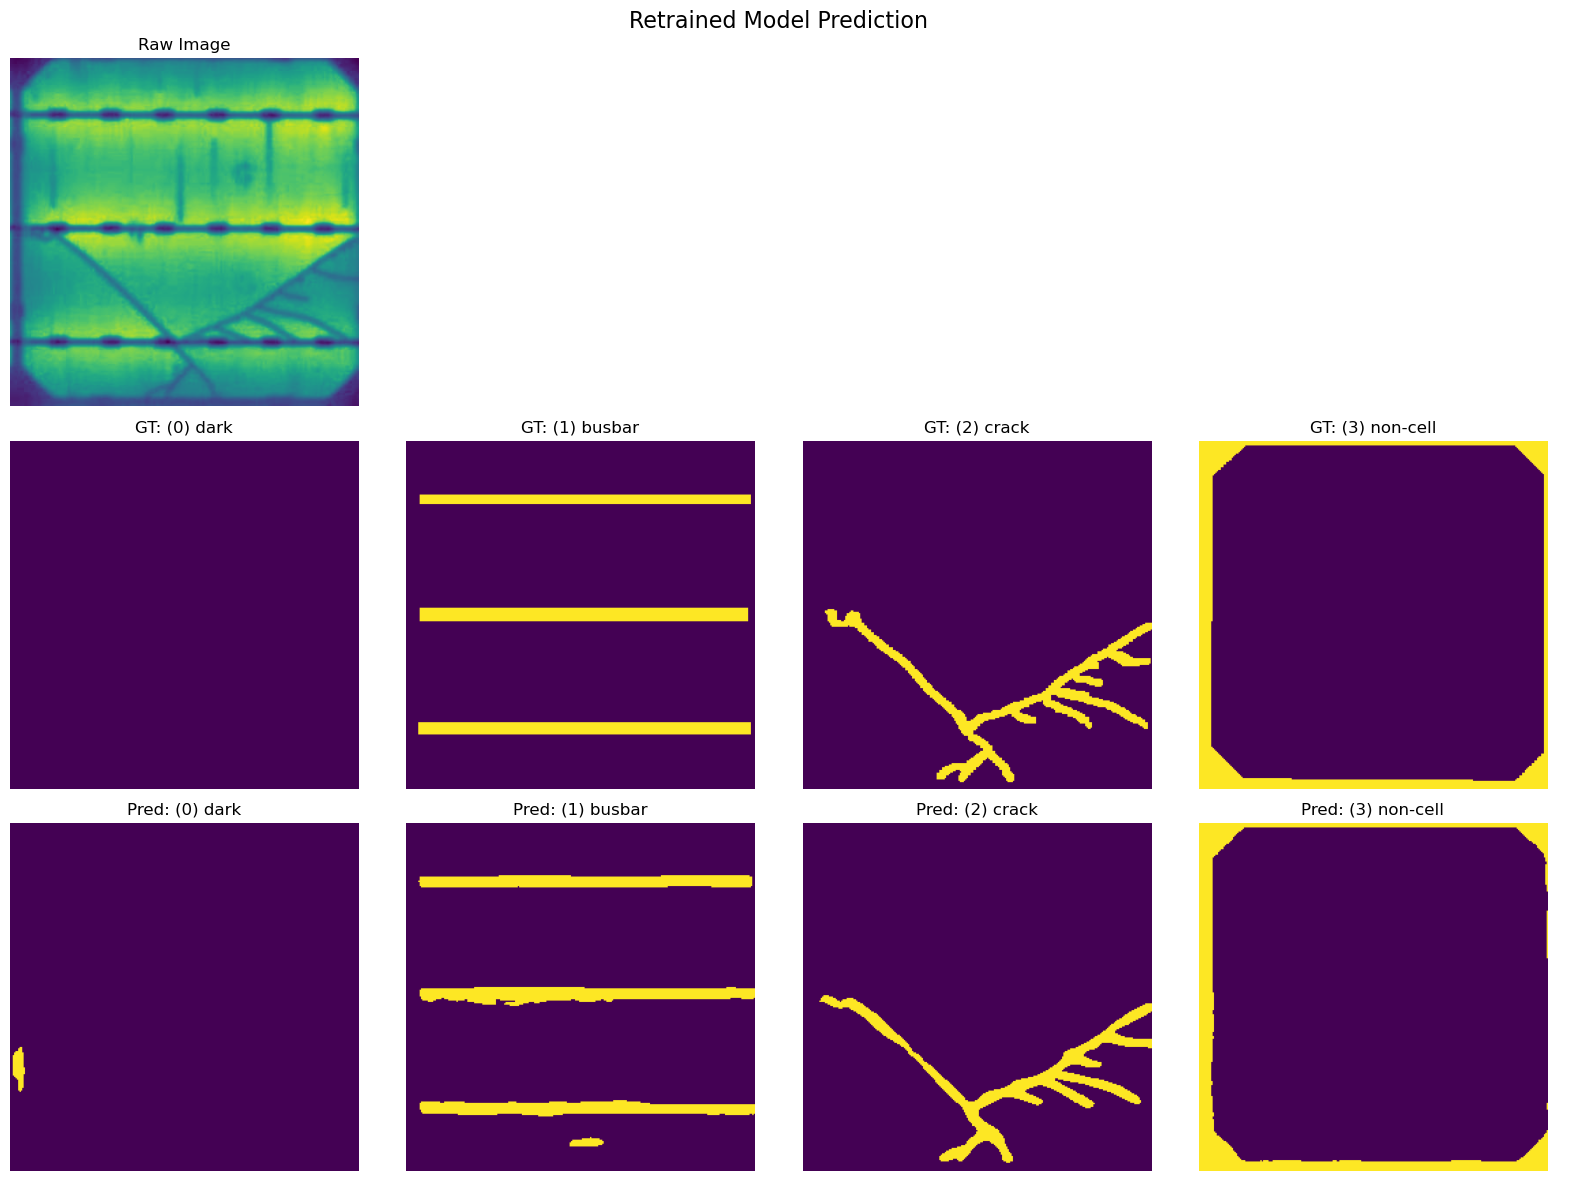

In [22]:
new_inference_and_show(6)

In [23]:
# for i in range(100):
#     new_inference_and_show(i)

[np.float64(0.3035749973672809), np.float64(0.126639364343701), np.float64(0.07654961164702069), np.float64(0.057251867414875465), np.float64(0.04804410994278662), np.float64(0.04324414778613683), np.float64(0.03965326342167276), np.float64(0.036998103965412484), np.float64(0.03553527297282761), np.float64(0.034242455791117565), np.float64(0.03335038880168489), np.float64(0.032948009726224525), np.float64(0.03225752285145449), np.float64(0.03181388542394747), np.float64(0.03121776091442867), np.float64(0.03049333407684709), np.float64(0.03014180510107315), np.float64(0.029734282641474045), np.float64(0.02955838498856985), np.float64(0.02920386056895509), np.float64(0.028697751236684395), np.float64(0.02875010624076381), np.float64(0.02816587525673888), np.float64(0.028317291543565014), np.float64(0.02841438790501067), np.float64(0.030214128592474895), np.float64(0.02835192751478065), np.float64(0.02774206004246618), np.float64(0.027199635225715058), np.float64(0.02660312509220658), np.

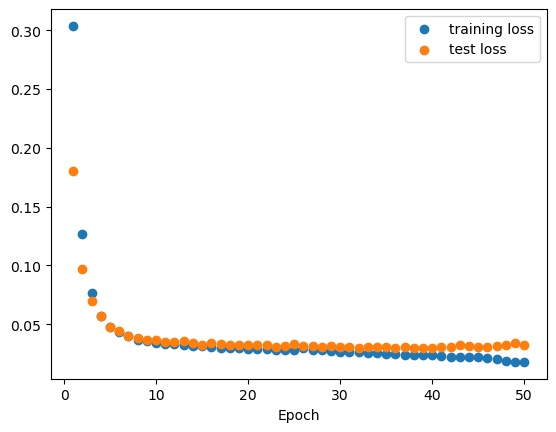

In [24]:
fig, ax = plt.subplots()

x = np.arange(1, len(training_epoch_loss) + 1, 1)

ax.scatter(x, training_epoch_loss, label='training loss')
ax.scatter(x, test_epoch_loss, label='test loss')
ax.legend()
ax.set_xlabel('Epoch')

print(training_epoch_loss)


In [25]:
test_epoch_loss

[np.float64(0.17998692207038403),
 np.float64(0.0970512330532074),
 np.float64(0.0694204056635499),
 np.float64(0.05720448773354292),
 np.float64(0.047259533777832985),
 np.float64(0.0443281102925539),
 np.float64(0.04007409745827317),
 np.float64(0.03837887430563569),
 np.float64(0.03690560581162572),
 np.float64(0.03636677097529173),
 np.float64(0.03463069908320904),
 np.float64(0.03500044206157327),
 np.float64(0.03560760500840843),
 np.float64(0.034189611207693815),
 np.float64(0.03256165119819343),
 np.float64(0.03417735546827316),
 np.float64(0.0331042162142694),
 np.float64(0.032544513233006),
 np.float64(0.03213697439059615),
 np.float64(0.03230968350544572),
 np.float64(0.03251602128148079),
 np.float64(0.03201757837086916),
 np.float64(0.030966701451689005),
 np.float64(0.031130752293393016),
 np.float64(0.03350919671356678),
 np.float64(0.031771585112437606),
 np.float64(0.031348332995548844),
 np.float64(0.031008875463157892),
 np.float64(0.03125839587301016),
 np.float64(0

In [27]:
save_dir

'/home/nrjost/githome/pvcracks_dev/retrain/training/Channeled_Combined_CWRU_LBNL_ASU//checkpoints/Channeled_Combined_CWRU_LBNL_ASU10'